Created by Xinlei Gao, Imperial College London, x.gao22@imperial.ac.uk  
This is a test version of internal pressure model of cyclindrical cells. e.g. 21700 


In [67]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
def Overwrite_Initial_L_SEI_0_Neg_Porosity(Para_0,cap_loss):
    """
    This is to overwrite the initial negative electrode porosity
    and initial SEI thickness (inner, outer) to be consistent
    with the initial capacity loss
    """
    delta_Q_SEI = cap_loss * 3600
    V_SEI = Para_0["Negative outer SEI partial molar volume [m3.mol-1]"]
    # do this when finish updating
    F = 96485.3
    A = Para_0["Electrode width [m]"] * Para_0["Electrode height [m]"]
    z_SEI = Para_0["Negative ratio of lithium moles to SEI moles"]
    L_neg = Para_0["Negative electrode thickness [m]"]
    eps_act_neg = Para_0["Negative electrode active material volume fraction"]
    R_neg =   Para_0["Negative particle radius [m]"]
    l_cr_init = Para_0["Negative electrode initial crack length [m]"]
    w_cr = Para_0["Negative electrode initial crack width [m]"]
    rho_cr = Para_0["Negative electrode number of cracks per unit area [m-2]"]
    a_neg = (3 * eps_act_neg / R_neg)
    roughness = 1 + 2 * l_cr_init * w_cr * rho_cr
    L_SEI_init = delta_Q_SEI  * V_SEI / (
        z_SEI * F * A * L_neg * a_neg * roughness)
 
    delta_epi = (L_SEI_init ) * roughness * a_neg
    L_inner_init = L_SEI_init / 2
    epi = 0.25 - delta_epi
    # print(L_inner_init,epi)
    # important: update here!
    Para_0["Negative electrode porosity"] = epi
    Para_0["Negative initial outer SEI thickness [m]"] = L_inner_init + 2.5e-9
    Para_0["Negative initial inner SEI thickness [m]"] = L_inner_init + 2.5e-9
    ## add Xinlei
    Para_0["Initial inner SEI thickness [m]"] = L_inner_init + 2.5e-9
    Para_0["Initial outer SEI thickness [m]"] = L_inner_init + 2.5e-9
    print(f"Has Overwritten Initial outer SEI thickness [m] to be {(L_inner_init+2.5e-9):.2e} and Negative electrode porosity to be {epi:.3f} to account for initial capacity loss of {cap_loss:.3f} Ah")
    print(f"Has Overwritten Initial outer SEI thickness [m] to be {(L_inner_init+2.5e-9):.2e} and Negative electrode porosity to be {epi:.3f} to account for initial capacity loss of {cap_loss:.3f} Ah")
 
    return Para_0

param = pybamm.ParameterValues("OKane2023_Xinlei")

Overwrite_Initial_L_SEI_0_Neg_Porosity(param,0.15)

Has Overwritten Initial outer SEI thickness [m] to be 1.62e-08 and Negative electrode porosity to be 0.219 to account for initial capacity loss of 0.150 Ah
Has Overwritten Initial outer SEI thickness [m] to be 1.62e-08 and Negative electrode porosity to be 0.219 to account for initial capacity loss of 0.150 Ah


{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': <function electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant at 0x7fc794e1fd30>,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0.013,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_OKane2022 at 0x7fc794e1f040>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'EC partial molar volume [m3.mol-1]': 6.667e-05,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant at 0x7fc794e1fee0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diff

In [68]:
import numpy as np


def Cal_V_add_SEI(Li_loss_SEI, z_SEI=2,V_SEI_eft=1):
    V_m_SEI = 1.0797e-4  # m³/mol, to be updated.
    Li_loss_SEI = np.asarray(Li_loss_SEI)
    V_add_SEI = V_SEI_eft * Li_loss_SEI * V_m_SEI / z_SEI
    return V_add_SEI

def Cal_V_add_Li(Li_loss_Li,V_Li_eft=1):
    V_m_Li = 1.3e-5  # m³/mol
    Li_loss_Li = np.asarray(Li_loss_Li)
    V_add_Li = V_Li_eft * Li_loss_Li * V_m_Li
    return V_add_Li

def Cal_V_jellyroll_wo_th(t_posCC_0, t_negCC_0, t_pos_0, t_neg_0, t_sep_0, width, height,\
                           t_pos_change, t_neg_change, pos_change_eft = 1, neg_change_eft = 1, Li_loss_SEI=None, Li_loss_Li=None,\
                              z_SEI=2,V_SEI_eft=1,V_Li_eft=1):
    ## Calculate JR volume change without thermal expansion
    ## update with a coeffient for pos and neg, repsepctively, 2024/9/4
    t_pos_change_new = np.asarray(t_pos_change) * pos_change_eft
    t_pos_change_new = np.asarray(t_neg_change) * neg_change_eft
    
    Total_thickness = t_posCC_0 + t_negCC_0 + (t_pos_0 + t_pos_change_new) + (t_neg_0 + t_pos_change_new) + t_sep_0
    Total_volume = Total_thickness * width * height
    
    # Calculate V_add_SEI and V_add_Li if provided
    V_add_SEI = Cal_V_add_SEI(Li_loss_SEI, z_SEI,V_SEI_eft) if Li_loss_SEI is not None else np.zeros_like(t_pos_change)
    V_add_Li = Cal_V_add_Li(Li_loss_Li,V_Li_eft) if Li_loss_Li is not None else np.zeros_like(t_pos_change)
    
    # Add the additional volumes
    Total_volume += V_add_SEI + V_add_Li
    
    return Total_volume

def Cal_V_jellyroll_w_th(t_posCC_0, t_negCC_0, t_pos_0, t_neg_0, t_sep_0, width, height,\
                          electrode_thickness_change_origin,electrode_change_eft=1, Li_loss_SEI=None, Li_loss_Li=None,\
                              z_SEI=2, V_SEI_eft=1,V_Li_eft=1):
    ## Calculate JR volume change without thermal expansion
    # different from above without thermal, here the coefficient only can change the original total thickness change
    electrode_thickness_change_origin_new = np.asarray(electrode_thickness_change_origin) * electrode_change_eft

    Total_thickness = t_posCC_0 + t_negCC_0 + (t_pos_0) + (t_neg_0) + t_sep_0 + electrode_thickness_change_origin_new
    Total_volume = Total_thickness * width * height
    
    # Calculate V_add_SEI and V_add_Li if provided
    V_add_SEI = Cal_V_add_SEI(Li_loss_SEI, z_SEI, V_SEI_eft) if Li_loss_SEI is not None else np.zeros_like(electrode_thickness_change_origin)
    V_add_Li = Cal_V_add_Li(Li_loss_Li, V_Li_eft) if Li_loss_Li is not None else np.zeros_like(electrode_thickness_change_origin)
    
    # Add the additional volumes
    Total_volume += V_add_SEI + V_add_Li
    
    return Total_volume
# Example usage:
# Li_loss_SEI = np.array([...])
# Li_loss_Li = np.array([...])
# Total_volume = Cal_V_jellyroll(t_posCC_0, t_negCC_0, t_pos_0, t_neg_0, t_sep_0, width, height, t_pos_change, t_neg_change, Li_loss_SEI, Li_loss_Li)


def Cal_P_gas(V_gas, n_gas_0, T_cell_K_array, n_add_gas=None):
    """
    计算气体压力的函数。

    参数:
    V_gas (array-like): 体积数组，以立方米为单位。
    n_gas_0 (float): 初始气体摩尔数。
    T_cell_K_array (array-like): 温度数组，以开尔文为单位。
    n_add_gas (array-like, optional): 增加的气体摩尔数数组。如果未提供，则默认为全零数组。

    返回:
    array: 气体压力数组，以帕斯卡（Pa）为单位。
    """
    # 确保输入是 NumPy 数组
    V_gas = np.asarray(V_gas)
    T_cell_K_array = np.asarray(T_cell_K_array)
    
    # 检查输入的形状
    if V_gas.shape != T_cell_K_array.shape:
        raise ValueError("输入的 V_gas 和 T_cell_K_array 必须具有相同的形状")
    
    # 如果 n_add_gas 未提供，创建与 V_gas 和 T_cell_K_array 相同形状的全零数组
    if n_add_gas is None:
        n_add_gas = np.zeros_like(V_gas)
    else:
        n_add_gas = np.asarray(n_add_gas)
        if V_gas.shape != n_add_gas.shape:
            raise ValueError("输入的 V_gas、n_add_gas 和 T_cell_K_array 必须具有相同的形状")
    
    # 计算总摩尔数
    n_gas = n_gas_0 + n_add_gas
    
    # 气体常数，单位 J/(mol·K)
    R = 8.314
    
    # 计算气体压力
    pressure = (n_gas * R * T_cell_K_array) / V_gas
    
    return pressure


def Cal_P_elec(T_cell_K_array, ratio_EC, ratio_EMC):
    """
    计算混合电解质蒸汽的部分压力。

    参数:
    T_cell_array (array-like): 温度数组，以开尔文（K）为单位。
    ratio_EC (float): EC 的比例。
    ratio_EMC (float): EMC 的比例。

    返回:
    array: 混合电解质蒸汽的部分压力，以帕斯卡（Pa）为单位。
    """
    
    # Pure EC parameters
    a_EC = 6.4897
    b_EC = 1836.57
    c_EC = -102.23
    
    # Pure EMC parameters
    a_EMC = 6.4308
    b_EMC = 1466.437
    c_EMC = -49.461
    
    # Ensure T_cell_array is a numpy array
    T_cell_K_array = np.asarray(T_cell_K_array)
    
    # Calculate partial pressures
    P_EC = 10 ** (a_EC - (b_EC / (c_EC + T_cell_K_array))) * 1000
    P_EMC = 10 ** (a_EMC - (b_EMC / (c_EMC + T_cell_K_array))) * 1000
    
    # Calculate mixed pressure
    P_mix = ratio_EC * P_EC + ratio_EMC * P_EMC
    
    return P_mix


def Cal_t_from_V(width,height,V_add):
    ##Calculate thickness change due to degradation loss
    t_add = V_add / (width * height)
    return t_add


def add_thickness_changes(t_change_orgin, t_add_SEI=None, t_add_Li=None):
    """
    将 t_change 与可选的 t_add_SEI 和 t_add_Li 数组相加的函数。
    
    参数:
    t_change_orgin (array-like): 原始的厚度变化数组。
    t_add_SEI (array-like, optional): 额外的 SEI 厚度变化数组，默认为 None。
    t_add_Li (array-like, optional): 额外的锂厚度变化数组，默认为 None。
    
    返回:
    numpy.ndarray: 添加 t_change、t_add_SEI 和 t_add_Li 后的结果数组。
    """
    # 创建 t_change_orgin 的副本，避免修改原始数组
    t_change = np.asarray(t_change_orgin).copy()
    
    if t_add_SEI is not None:
        t_add_SEI = np.asarray(t_add_SEI)
        t_change += t_add_SEI
        
    if t_add_Li is not None:
        t_add_Li = np.asarray(t_add_Li)
        t_change += t_add_Li
    
    return t_change


def Cal_add_gas_SEI(z_SEI, Loss_Li_SEI, coefficient_gas_SEI):
    """
    Function to calculate the additional gases released from SEI growth.
    
    Parameters:
    Loss_Li_SEI: lithium loss to SEI
    z_SEI: If two-electron reaction, then z_SEI =2 
    
    Returns:
    numpy.ndarray: 
    """
    # Simply add a coefficient to fit the gas generation
    n_gas_SEI = coefficient_gas_SEI * Loss_Li_SEI / z_SEI

    return n_gas_SEI

In [69]:
print(param["Negative electrode partial molar volume [m3.mol-1]"])
print(param["Negative electrode critical stress [Pa]"])
param["Negative electrode critical stress [Pa]"] = 6e8
print(param["Negative electrode critical stress [Pa]"])

print(param["Positive electrode partial molar volume [m3.mol-1]"])
param["Positive electrode partial molar volume [m3.mol-1]"]=7.88e-7
print(param["Positive electrode partial molar volume [m3.mol-1]"])

print(param["Positive electrode critical stress [Pa]"])

print(param["Initial concentration in negative electrode [mol.m-3]"])
param["Initial concentration in negative electrode [mol.m-3]"] = 28600
print(param["Initial concentration in negative electrode [mol.m-3]"])


print(param["Initial concentration in positive electrode [mol.m-3]"])
param["Initial concentration in positive electrode [mol.m-3]"] = 13100
print(param["Initial concentration in positive electrode [mol.m-3]"])


print(param["Cell thermal expansion coefficient [m.K-1]"])
param["Cell thermal expansion coefficient [m.K-1]"] = 0.23e-6
param["Cell thermal expansion coefficient [m.K-1]"] = 0.18e-6 # reduced 09/04 to reduce the thermal effects
print(param["Cell thermal expansion coefficient [m.K-1]"])


print(param["Total heat transfer coefficient [W.m-2.K-1]"])
param["Total heat transfer coefficient [W.m-2.K-1]"] =17
print(param["Total heat transfer coefficient [W.m-2.K-1]"])

3.1e-06
60000000.0
600000000.0
7.88e-07
7.88e-07
2000000000.0
28800
28600
12729.0
13100
1.1e-06
1.8e-07
15.0
17


In [70]:
# Ageing paramters 
print(param["Outer SEI solvent diffusivity [m2.s-1]"])
print(param["Positive outer SEI solvent diffusivity [m2.s-1]"])
print(param["Negative outer SEI solvent diffusivity [m2.s-1]"])

D_sol = 5e-21
param["Outer SEI solvent diffusivity [m2.s-1]"] = D_sol
param["Positive outer SEI solvent diffusivity [m2.s-1]"] = D_sol
param["Negative outer SEI solvent diffusivity [m2.s-1]"] = D_sol

print(param["Outer SEI solvent diffusivity [m2.s-1]"])
print(param["Positive outer SEI solvent diffusivity [m2.s-1]"])
print(param["Negative outer SEI solvent diffusivity [m2.s-1]"])


2.5000000000000002e-22
2.5000000000000002e-22
2.5000000000000002e-22
5e-21
5e-21
5e-21


In [71]:
## Test on 1/10C cycling
import pybamm
import matplotlib.pyplot as plt

model = pybamm.lithium_ion.DFN(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        "open-circuit potential": "current sigmoid",
        "SEI": "solvent-diffusion limited",
        #"SEI": "interstitial-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        "thermal": "lumped", 
    }
)

#param = pybamm.ParameterValues("OKane2023_Xinlei")
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

cycle_number = 3

exp = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Charge at C/3 until 4.2 V",
            "Hold at 4.2 V until C/20",
            "Discharge at 1C until 2.5 V",  # ageing cycles
            #"Discharge at 1C until 2.5 V"

        )
    ]
    * cycle_number
    #+ ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)



sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts)
#sim_thermal = pybamm.Simulation(model_thermal, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve(initial_soc=0)
#sol_thermal = sim_thermal.solve()



At t = 105.476 and h = 4.00056e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.477 and h = 8.70913e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.477 and h = 1.76048e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.393 and h = 3.91629e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.393 and h = 1.02574e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.393 and h = 1.03478e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.0594 and h = 9.55157e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.0595 and h = 1.26512e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.0595 and h = 4.93035e-12, the corrector convergence failed repeatedly or with |h| = hmin.


In [72]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cwd = os.getcwd()


# 读取 pickle 文件
#pickle_file_path = cwd + '/docs/source/examples/notebooks/models/exp_LG/processed_data.pkl'
pickle_file_path = cwd + '/exp_LG/processed_data.pkl'
cycles_df = pd.read_pickle(pickle_file_path)
print("DataFrame loaded from pickle file")
print(cycles_df.head())


# 提取每个循环的最后一个 Q_dis 和 Q_cha 非零值
summary_data = []

for cycle in cycles_df.index.levels[0]:
    cycle_data = cycles_df.loc[cycle]
    last_q_dis = cycle_data[cycle_data['Q_dis'] > 0]['Q_dis'].iloc[-1] if not cycle_data[cycle_data['Q_dis'] > 0].empty else 0
    last_q_cha = cycle_data[cycle_data['Q_cha'] > 0]['Q_cha'].iloc[-1] if not cycle_data[cycle_data['Q_cha'] > 0].empty else 0
    summary_data.append([cycle, last_q_cha, last_q_dis])

# 创建一个新的 DataFrame 存储结果
summary_df = pd.DataFrame(summary_data, columns=['Cycle', 'Last_Q_cha', 'Last_Q_dis'])
# 假设初始值为 initial_pressure_value
#initial_pressure_value = 1 #[bar]  # 可以根据实际情况调整
initial_pressure_value = 1.26 #[bar]  

# 对每个压力列加上初始值
pressure_1 = cycles_df.loc[1]["Pressure"]/1000 + initial_pressure_value
pressure_2 = cycles_df.loc[2]["Pressure"]/1000  + initial_pressure_value
pressure_3 = cycles_df.loc[3]["Pressure"]/1000  + initial_pressure_value

# 合并相对时间列
merged_cycles_pressure = pd.concat([cycles_df.loc[1]["RelativeTime"] - cycles_df.loc[1]["RelativeTime"].iloc[1], 
                                    cycles_df.loc[2]["RelativeTime"] - cycles_df.loc[1]["RelativeTime"].iloc[1],
                                    cycles_df.loc[3]["RelativeTime"] - cycles_df.loc[1]["RelativeTime"].iloc[1]])

# 合并压力列
merged_pressure = pd.concat([pressure_1, pressure_2, pressure_3])

# 创建一个新的 DataFrame 包含相对时间和压力
merged_df = pd.DataFrame({'RelativeTime': merged_cycles_pressure, 'Pressure': merged_pressure})

# 重置索引
merged_df.reset_index(drop=True, inplace=True)

import matplotlib.pyplot as plt

# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

DataFrame loaded from pickle file
            Mode  RelativeTime   Voltage          I  Q_dis     Q_cha  \
Cycle Step                                                             
1     1      1.0        0.0000  2.680430  1407.8055    0.0  0.000078   
      2      1.0        0.0084  2.690530  1574.4427    0.0  0.003691   
      3      1.0        0.0294  2.700598  1640.2499    0.0  0.013108   
      4      1.0        0.0634  2.710643  1664.4644    0.0  0.028749   
      5      1.0        0.1074  2.720645  1668.5892    0.0  0.049123   

                 Cap         R    Pressure  Temperature  
Cycle Step                                               
1     1     0.000078  1.903978  159.026607      25.3794  
      2     0.003691  1.708878  158.944819      25.3885  
      3     0.013108  1.646455  158.998347      25.4014  
      4     0.028749  1.628537  159.049016      25.4088  
      5     0.049123  1.630506  158.990980      25.4014  


In [73]:
## new test  to see why SOC+thermal increases 
V_cell = 2.424e-5 # [m3]
#Void_ratio = 0.1  # No longer use, now is updated by substratcing jellyroll volume from the total  volume
#V_void = V_cell * Void_ratio # [m3]

t_posCC_0 = param["Positive current collector thickness [m]"]
t_negCC_0 = param["Negative current collector thickness [m]"]
t_pos_0 = param["Positive electrode thickness [m]"]
t_neg_0 = param["Negative electrode thickness [m]"]
t_sep_0 = param["Separator thickness [m]"]
width = param["Electrode width [m]"]
height = param["Electrode height [m]"]
t_pos_change = sol["Positive electrode thickness change [m]"].entries
t_neg_change = sol["Negative electrode thickness change [m]"].entries
#Thickness to pos and neg, purely lithiation effect
t_lithiation = t_pos_change + t_neg_change
# Thickness change variable obtained from PyBaMM source code
t_total_change_origin = sol["Cell thickness change [m]"].entries #noted SEI and Li plating directly goes to volume for calculating pressure 
# Thermal thickness change
t_thermal = t_total_change_origin - t_lithiation 

# degradation loss and resulting volume change
Li_loss_SEI = sol["Loss of lithium to negative SEI [mol]"].entries + sol["Loss of lithium to negative SEI on cracks [mol]"].entries
V_add_SEI = Cal_V_add_SEI(Li_loss_SEI=Li_loss_SEI,z_SEI=2, V_SEI_eft=1)
Li_loss_Li = sol["Loss of lithium to negative lithium plating [mol]"].entries
V_add_Li = Cal_V_add_Li(Li_loss_Li=Li_loss_Li, V_Li_eft=1)

# Calculate addtional gas from side reactions
n_gas_SEI = Cal_add_gas_SEI(Loss_Li_SEI=Li_loss_SEI, z_SEI=2, coefficient_gas_SEI=0) # Simplest assumption, no decay

# Calculate thickness change due to degradation/ side reactions 
t_SEI = Cal_t_from_V(width=width,height=height,V_add=V_add_SEI)
t_Li = Cal_t_from_V(width=width,height=height,V_add=V_add_Li)

t_total_change = add_thickness_changes(t_change_orgin=t_total_change_origin,t_add_SEI=t_SEI,t_add_Li=t_Li)

In [74]:
# degradation loss and resulting volume change
Li_loss_SEI = sol["Loss of lithium to negative SEI [mol]"].entries + sol["Loss of lithium to negative SEI on cracks [mol]"].entries
V_add_SEI = Cal_V_add_SEI(Li_loss_SEI=Li_loss_SEI,z_SEI=2, V_SEI_eft=1)
Li_loss_Li = sol["Loss of lithium to negative lithium plating [mol]"].entries
V_add_Li = Cal_V_add_Li(Li_loss_Li=Li_loss_Li, V_Li_eft=1)

# Calculate addtional gas from side reactions
n_gas_SEI = Cal_add_gas_SEI(Loss_Li_SEI=Li_loss_SEI, z_SEI=2, coefficient_gas_SEI=0) # Simplest assumption, no decay

# Calculate thickness change due to degradation/ side reactions 
t_SEI = Cal_t_from_V(width=width,height=height,V_add=V_add_SEI)
t_Li = Cal_t_from_V(width=width,height=height,V_add=V_add_Li)

t_total_change = add_thickness_changes(t_change_orgin=t_total_change_origin,t_add_SEI=t_SEI,t_add_Li=t_Li)

In [75]:
time = sol["Time [min]"].entries
Voltage = sol["Terminal voltage [V]"].entries

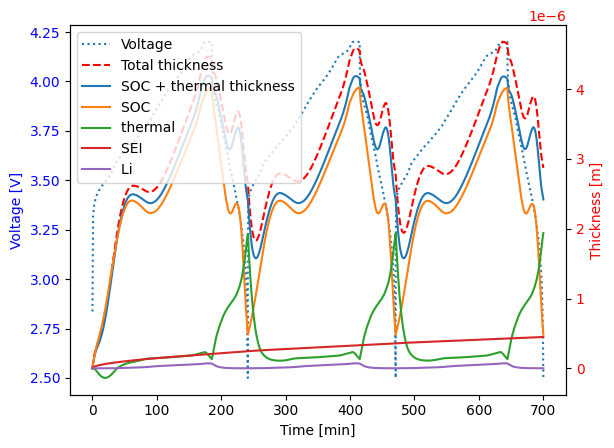

In [76]:
import matplotlib.pyplot as plt


# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, t_total_change, label="Total thickness", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.plot(time, t_total_change_origin, label="SOC + thermal thickness")  # 在次轴上绘制 Thickness

ax2.plot(time, t_lithiation, label="SOC ")  # 在次轴上绘制 Thickness
ax2.plot(time, t_thermal, label="thermal ")  # 在次轴上绘制 Thickness
ax2.plot(time, t_SEI, label="SEI ")
ax2.plot(time, t_Li, label="Li ")
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

In [96]:
V_cell = 2.424e-5 # [m3]
#Void_ratio = 0.1  # No longer use, now is updated by substratcing jellyroll volume from the total  volume
#V_void = V_cell * Void_ratio # [m3]

t_posCC_0 = param["Positive current collector thickness [m]"]
t_negCC_0 = param["Negative current collector thickness [m]"]
t_pos_0 = param["Positive electrode thickness [m]"]
t_neg_0 = param["Negative electrode thickness [m]"]
t_sep_0 = param["Separator thickness [m]"]
width = param["Electrode width [m]"]
height = param["Electrode height [m]"]
t_pos_change = sol["Positive electrode thickness change [m]"].entries
t_neg_change = sol["Negative electrode thickness change [m]"].entries


#Thickness to pos and neg, purely lithiation effect
t_lithiation = t_pos_change + t_neg_change

# Thickness change variable obtained from PyBaMM source code
t_total_change_origin = sol["Cell thickness change [m]"].entries #noted SEI and Li plating directly goes to volume for calculating pressure 

# Thermal thickness change
t_thermal = t_total_change_origin - t_lithiation 

# degradation loss and resulting volume change
Li_loss_SEI = sol["Loss of lithium to negative SEI [mol]"].entries + sol["Loss of lithium to negative SEI on cracks [mol]"].entries
V_add_SEI = Cal_V_add_SEI(Li_loss_SEI=Li_loss_SEI,z_SEI=2, V_SEI_eft=1)
Li_loss_Li = sol["Loss of lithium to negative lithium plating [mol]"].entries
V_add_Li = Cal_V_add_Li(Li_loss_Li=Li_loss_Li, V_Li_eft=1)

# Calculate addtional gas from side reactions
n_gas_SEI = Cal_add_gas_SEI(Loss_Li_SEI=Li_loss_SEI, z_SEI=2, coefficient_gas_SEI=0) # Simplest assumption, no decay

# Calculate thickness change due to degradation/ side reactions 
t_SEI = Cal_t_from_V(width=width,height=height,V_add=V_add_SEI)
t_Li = Cal_t_from_V(width=width,height=height,V_add=V_add_Li)

t_total_change = add_thickness_changes(t_change_orgin=t_total_change_origin,t_add_SEI=t_SEI,t_add_Li=t_Li)

T_cell_K = sol["X-averaged cell temperature [K]"].entries
T_cell_C = sol["X-averaged cell temperature [C]"].entries
# JR volume change without thermal expansion
V_jellyroll_wo_th = Cal_V_jellyroll_wo_th(t_posCC_0,t_negCC_0,t_pos_0,t_neg_0,t_sep_0,width,height,
                              t_pos_change,t_neg_change, pos_change_eft=0.7, neg_change_eft=0.7,
                              Li_loss_SEI=Li_loss_SEI,Li_loss_Li=Li_loss_Li,z_SEI=2,
                              V_SEI_eft=1,V_Li_eft=1)## update with eft to control the reservible range 09/04
# JR volume change with thermal expansion
V_jellyroll_w_th = Cal_V_jellyroll_w_th(t_posCC_0,t_negCC_0,t_pos_0,t_neg_0,t_sep_0,width,height,
                              electrode_thickness_change_origin=t_total_change_origin, electrode_change_eft=0.7,
                              Li_loss_SEI=Li_loss_SEI,Li_loss_Li=Li_loss_Li,z_SEI=2,
                              V_SEI_eft=1,V_Li_eft=1) ## update with eft to control the reservible range 09/04

Electrode_expansion_eft = 1
V_void = (V_cell - V_jellyroll_w_th * Electrode_expansion_eft)



n_0 = 2.02e-4 # [mol]
##n_add_gas = 0 #不传入n_add_gas
P_gas = Cal_P_gas(V_gas=V_void, n_gas_0=n_0, T_cell_K_array= T_cell_K) 
#P_gas = Cal_P_gas(V_gas=V_void, n_gas_0=n_0, T_cell_K_array= T_cell_K,n_add_gas=n_gas_SEI) 
#P_gas = Cal_P_gas(V_gas=V_void, n_gas_0=n_0, T_cell_K_array= T_cell_K) 


P_elec = Cal_P_elec(T_cell_K_array=T_cell_K, ratio_EC=0.3, ratio_EMC=0.7) # EC:EMC = 3:7

P_cell = P_gas + P_elec

P_bar = 101325 # Pa->bar
P_cell_bar = P_cell/P_bar

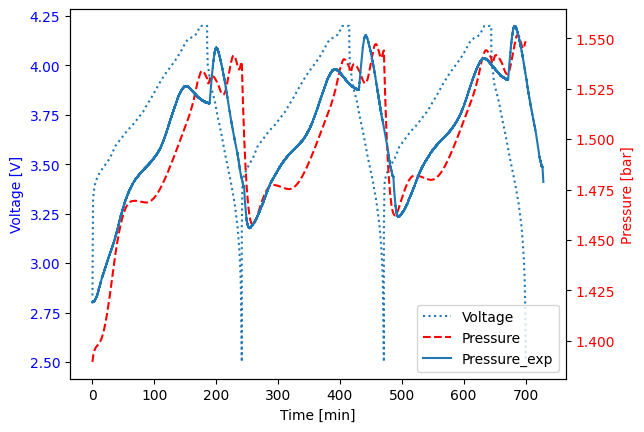

In [97]:
# 假设初始值为 initial_pressure_value
#initial_pressure_value = 1 #[bar]  # 可以根据实际情况调整
initial_pressure_value = 1.26 #[bar]  

# 对每个压力列加上初始值
pressure_1 = cycles_df.loc[1]["Pressure"]/1000 + initial_pressure_value
pressure_2 = cycles_df.loc[2]["Pressure"]/1000  + initial_pressure_value
pressure_3 = cycles_df.loc[3]["Pressure"]/1000  + initial_pressure_value

# 合并相对时间列
merged_cycles_pressure = pd.concat([cycles_df.loc[1]["RelativeTime"] - cycles_df.loc[1]["RelativeTime"].iloc[1], 
                                    cycles_df.loc[2]["RelativeTime"] - cycles_df.loc[1]["RelativeTime"].iloc[1],
                                    cycles_df.loc[3]["RelativeTime"] - cycles_df.loc[1]["RelativeTime"].iloc[1]])

# 合并压力列
merged_pressure = pd.concat([pressure_1, pressure_2, pressure_3])

# 创建一个新的 DataFrame 包含相对时间和压力
merged_df = pd.DataFrame({'RelativeTime': merged_cycles_pressure, 'Pressure': merged_pressure})

# 重置索引
merged_df.reset_index(drop=True, inplace=True)

import matplotlib.pyplot as plt

# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
#ax1.plot(merged_cycles_voltage/60, merged_voltage,label="Voltage_exp")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, P_cell_bar, label="Pressure", linestyle="dashed", color='r')
ax2.plot(merged_cycles_pressure/60, merged_pressure,label="Pressure_exp")  # 在次轴上绘制 Thickness
ax2.set_ylabel("Pressure [bar]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

充电容量: [4.988705525664177, 4.663253717281614, 4.657535937592447]
放电容量: [4.663366661839197, 4.6576285775350925, 4.652936387793432]


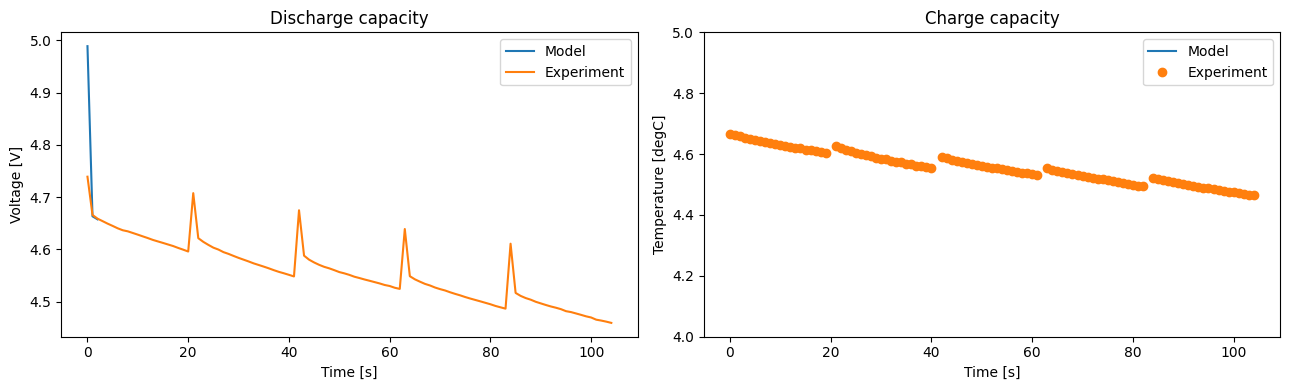

In [98]:
def calculate_capacities(sol):
    # 初始化充电容量和放电容量列表
    charge_capacities = []
    discharge_capacities = []

    # 遍历sol数据结构中的每个循环
    for cycle in sol.cycles:
        # 获取第一个步骤的放电容量时间序列
        step1_times = cycle.steps[0]["Discharge capacity [A.h]"].entries
        # 获取第二个步骤的放电容量时间序列
        step2_times = cycle.steps[1]["Discharge capacity [A.h]"].entries
        # 获取第三个步骤的放电容量时间序列
        step3_times = cycle.steps[2]["Discharge capacity [A.h]"].entries

        # 计算第一个步骤的初始值和第二个步骤的最后值的差（充电容量）
        charge_capacity = step2_times[-1] - step1_times[0]
        charge_capacities.append((-1) * charge_capacity)
        
        # 计算第三步的初始值和最后值的差（放电容量）
        discharge_capacity = step3_times[-1] - step3_times[0]
        discharge_capacities.append(discharge_capacity)

    # 返回计算结果
    return charge_capacities, discharge_capacities

# 假设 sol 已定义并包含需要的数据
# 调用函数并接收结果
charge_capacities, discharge_capacities = calculate_capacities(sol)

# 输出结果
print("充电容量:", charge_capacities)
print("放电容量:", discharge_capacities)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries

ax1.plot(charge_capacities)
ax1.plot(summary_df["Last_Q_cha"]/1000, )
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Discharge capacity")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(discharge_capacities)
ax2.plot(summary_df["Last_Q_dis"]/1000, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Charge capacity")
ax2.set_ylim(4,5)
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

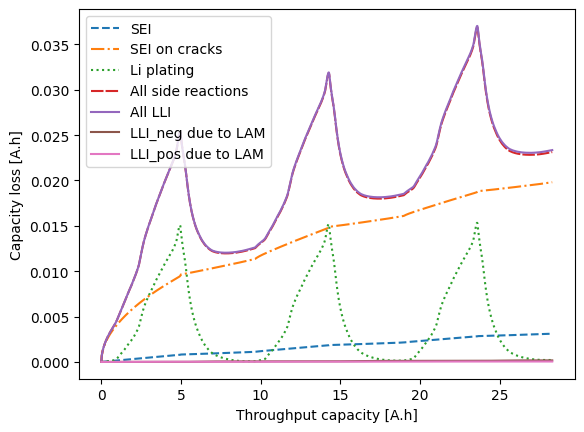

In [99]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h

Q_LLI_due2_LAM_neg = (
    sol["Loss of lithium due to loss of active material in negative electrode [mol]"].entries * 96485.3 / 3600
)
Q_LLI_due2_LAM_pos = (
    sol["Loss of lithium due to loss of active material in positive electrode [mol]"].entries * 96485.3 / 3600
)
plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
plt.plot(Qt, Q_LLI, label="All LLI")
plt.plot(Qt, Q_LLI_due2_LAM_neg, label="LLI_neg due to LAM")
plt.plot(Qt, Q_LLI_due2_LAM_pos, label="LLI_pos due to LAM")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

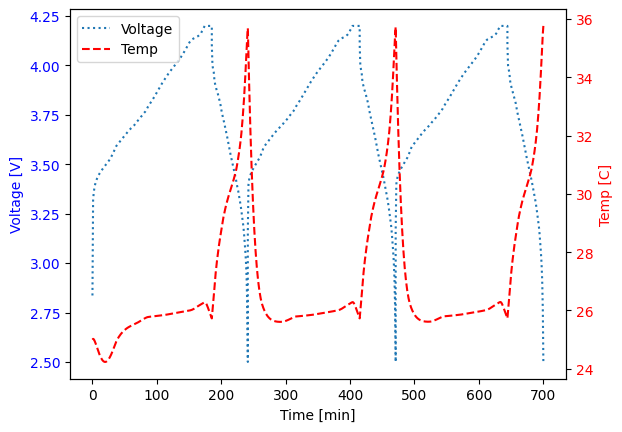

In [100]:
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, T_cell_C, label="Temp", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Temp [C]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

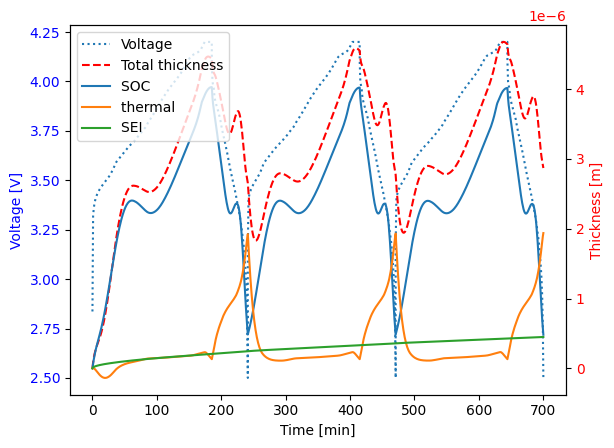

In [101]:
import matplotlib.pyplot as plt


# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, t_total_change, label="Total thickness", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
#ax2.plot(time, t_total_change_origin, label="SOC + thermal thickness")  # 在次轴上绘制 Thickness

ax2.plot(time, t_lithiation, label="SOC ")  # 在次轴上绘制 Thickness
ax2.plot(time, t_thermal, label="thermal ")  # 在次轴上绘制 Thickness
ax2.plot(time, t_SEI, label="SEI ")
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

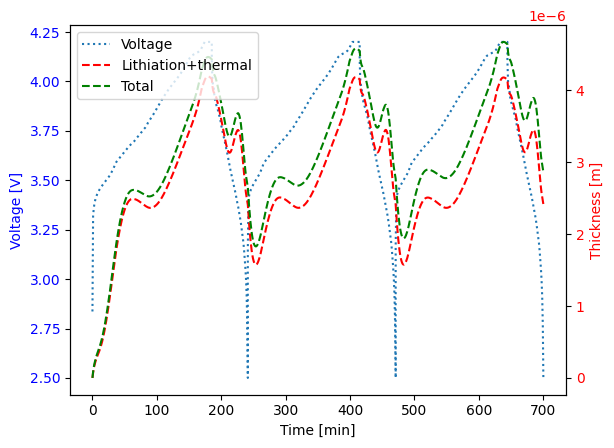

In [102]:
# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, sol["Cell thickness change [m]"].entries, label="Lithiation+thermal", linestyle="dashed", color='r')
ax2.plot(time, t_total_change, label="Total", linestyle="dashed", color='g')  # 在次轴上绘制 Thickness
#ax2.plot(time, t_thermal, label="Thermal", color='r')  # 在次轴上绘制 Thickness

#ax2.plot(time, t_total_change_origin, label="SOC + thermal thickness")  # 在次轴上绘制 Thickness
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

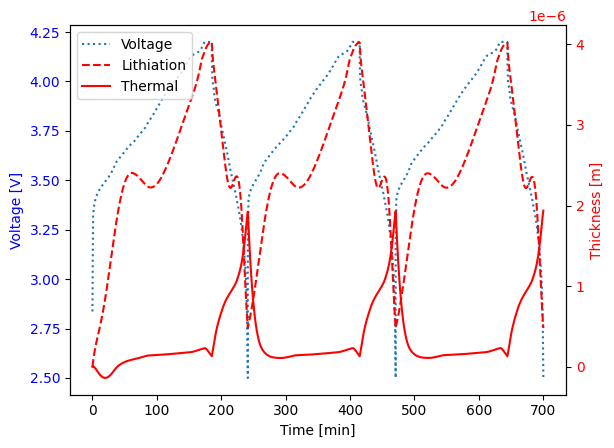

In [103]:

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, t_lithiation, label="Lithiation", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.plot(time, t_thermal, label="Thermal", color='r')  # 在次轴上绘制 Thickness

#ax2.plot(time, t_total_change_origin, label="SOC + thermal thickness")  # 在次轴上绘制 Thickness
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

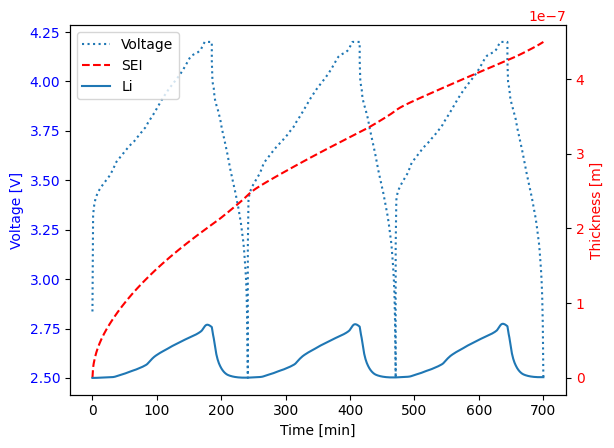

In [104]:
# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, t_SEI, label="SEI", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.plot(time, t_Li, label="Li")  # 在次轴上绘制 Thickness
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

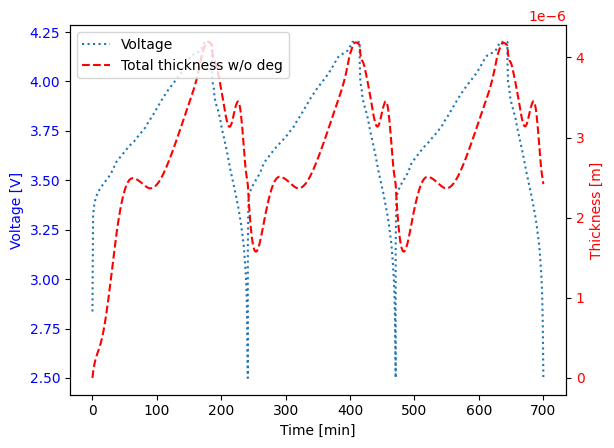

In [105]:
# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, t_total_change_origin, label="Total thickness w/o deg", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

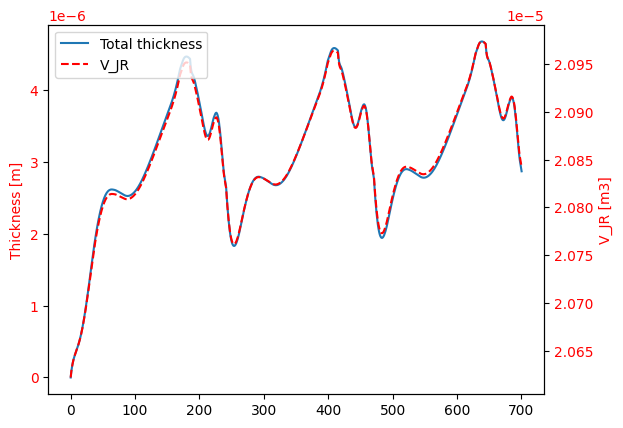

In [106]:
# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
#ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.plot(time, t_total_change, label="Total thickness")  # 在次轴上绘制 Thickness
ax1.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='r') 

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, V_jellyroll_w_th, label="V_JR", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("V_JR [m3]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

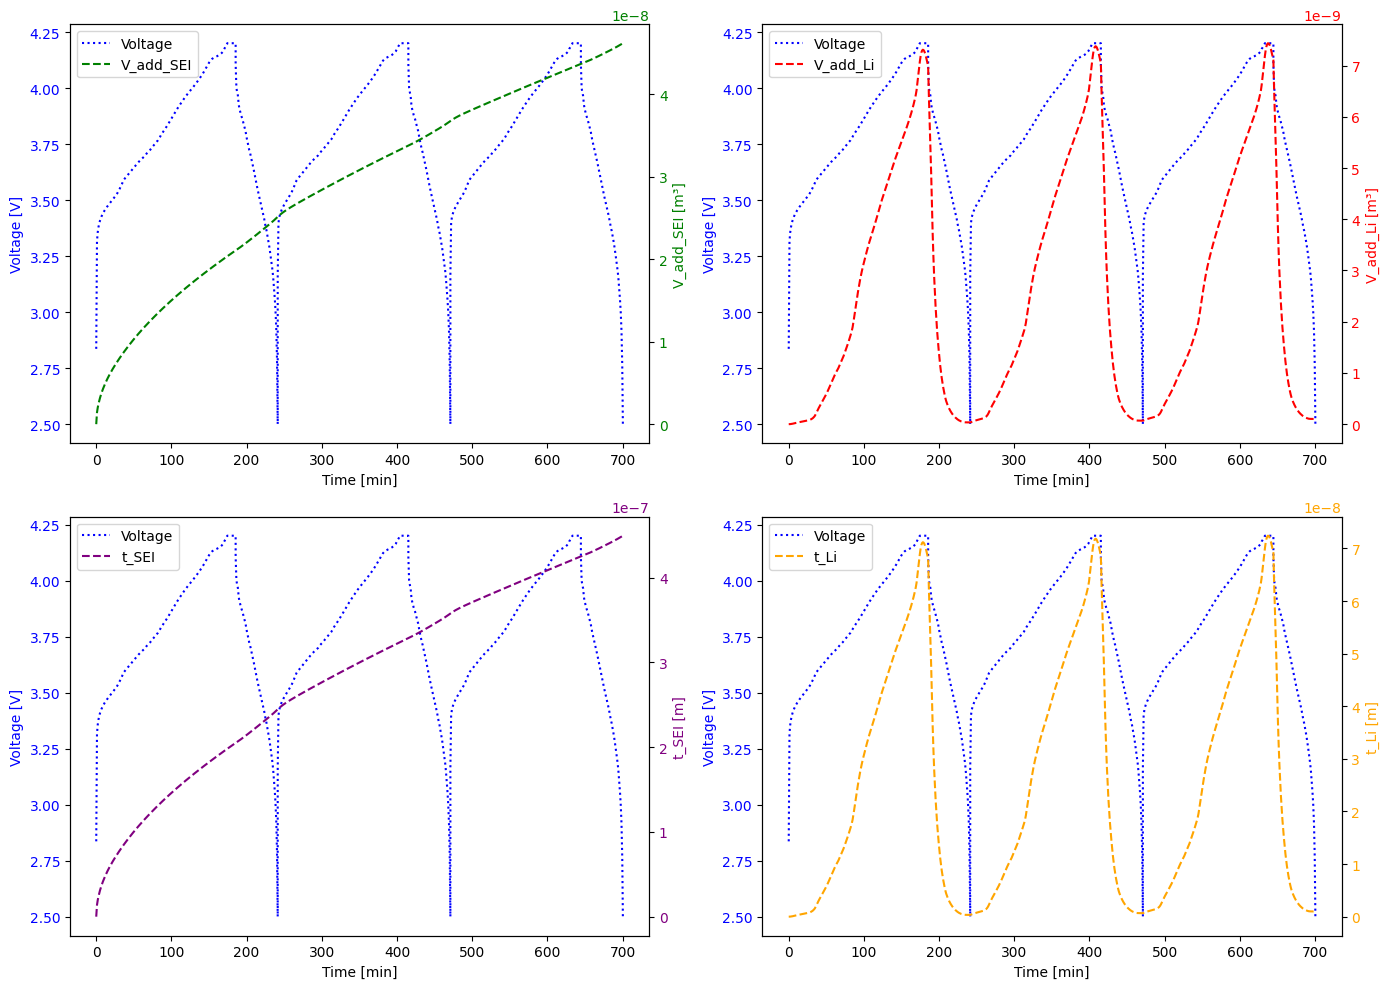

In [107]:
# 创建图形和主轴
fig, ((ax1, ax3), (ax5, ax7)) = plt.subplots(2, 2, figsize=(14, 10))

# 左上图
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted", color='b')
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, V_add_SEI, label="V_add_SEI", linestyle="dashed", color='g')
ax2.set_ylabel("V_add_SEI [m³]", color='g')
ax2.tick_params(axis='y', labelcolor='g')

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 右上图
ax3.plot(time, Voltage, label="Voltage", linestyle="dotted", color='b')
ax3.set_xlabel("Time [min]")
ax3.set_ylabel("Voltage [V]", color='b')
ax3.tick_params(axis='y', labelcolor='b')

ax4 = ax3.twinx()
ax4.plot(time, V_add_Li, label="V_add_Li", linestyle="dashed", color='r')
ax4.set_ylabel("V_add_Li [m³]", color='r')
ax4.tick_params(axis='y', labelcolor='r')

# 添加图例
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper left')

# 左下图
ax5.plot(time, Voltage, label="Voltage", linestyle="dotted", color='b')
ax5.set_xlabel("Time [min]")
ax5.set_ylabel("Voltage [V]", color='b')
ax5.tick_params(axis='y', labelcolor='b')

ax6 = ax5.twinx()
ax6.plot(time, t_SEI, label="t_SEI", linestyle="dashed", color='purple')
ax6.set_ylabel("t_SEI [m]", color='purple')
ax6.tick_params(axis='y', labelcolor='purple')

# 添加图例
lines5, labels5 = ax5.get_legend_handles_labels()
lines6, labels6 = ax6.get_legend_handles_labels()
ax5.legend(lines5 + lines6, labels5 + labels6, loc='upper left')

# 右下图
ax7.plot(time, Voltage, label="Voltage", linestyle="dotted", color='b')
ax7.set_xlabel("Time [min]")
ax7.set_ylabel("Voltage [V]", color='b')
ax7.tick_params(axis='y', labelcolor='b')

ax8 = ax7.twinx()
ax8.plot(time, t_Li, label="t_Li", linestyle="dashed", color='orange')
ax8.set_ylabel("t_Li [m]", color='orange')
ax8.tick_params(axis='y', labelcolor='orange')

# 添加图例
lines7, labels7 = ax7.get_legend_handles_labels()
lines8, labels8 = ax8.get_legend_handles_labels()
ax7.legend(lines7 + lines8, labels7 + labels8, loc='upper left')

plt.tight_layout()
plt.show()

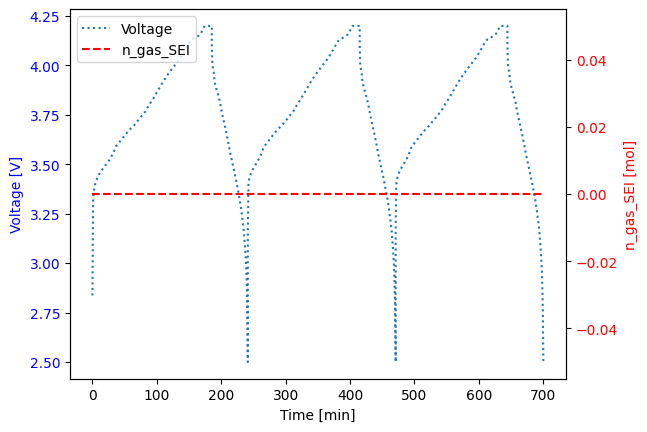

In [108]:
import matplotlib.pyplot as plt

# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, n_gas_SEI, label="n_gas_SEI", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("n_gas_SEI [mol]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

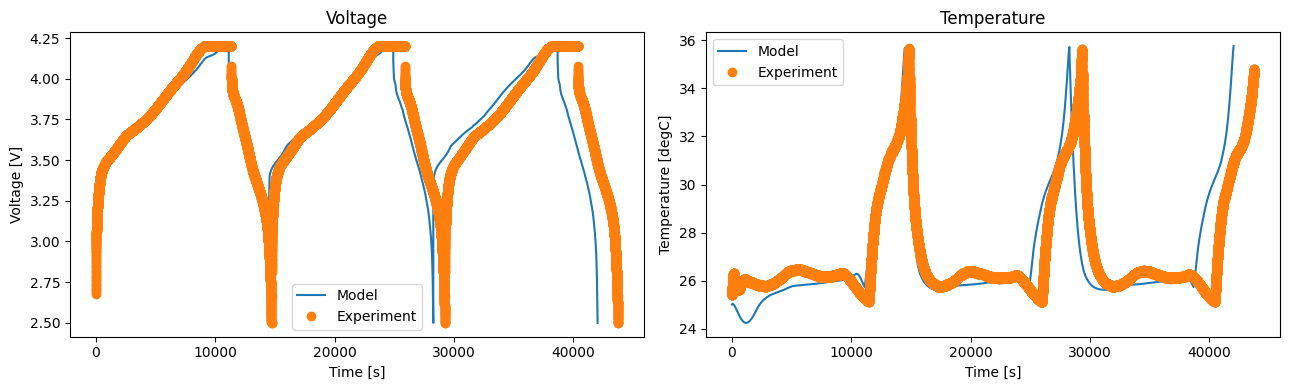

In [109]:
# Merge the first two cycles for Voltage and Temperature
merged_cycles_voltage = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_voltage = pd.concat([cycles_df.loc[1]["Voltage"], cycles_df.loc[2]["Voltage"],cycles_df.loc[3]["Voltage"]])

merged_cycles_temperature = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1], 
                                       cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                       cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_temperature = pd.concat([cycles_df.loc[1]["Temperature"], cycles_df.loc[2]["Temperature"], cycles_df.loc[3]["Temperature"]])

merged_cycles_pressure = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1], 
                                       cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                       cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_pressure = pd.concat([cycles_df.loc[1]["Pressure"], cycles_df.loc[2]["Pressure"], cycles_df.loc[3]["Pressure"]])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol_nodeg = sol["Time [s]"].entries

ax1.plot(t_sol_nodeg, sol["Voltage [V]"](t_sol_nodeg))
ax1.plot(merged_cycles_voltage, merged_voltage, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(t_sol_nodeg, sol["X-averaged cell temperature [C]"](t_sol_nodeg))
ax2.plot(merged_cycles_temperature, merged_temperature, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

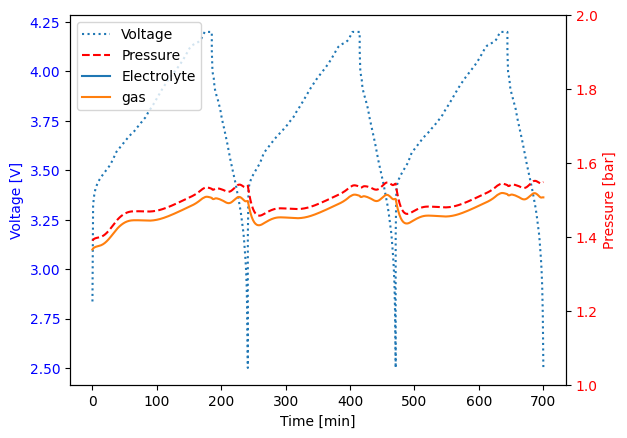

In [110]:
# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, P_cell_bar, label="Pressure", linestyle="dashed", color='r')
ax2.plot(time, P_elec/101325, label = "Electrolyte")  
ax2.plot(time, P_gas/101325, label = "gas")
ax2.set_ylabel("Pressure [bar]", color='r')  # 设置颜色和标签以区分
ax2.set_ylim(1, 2)  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

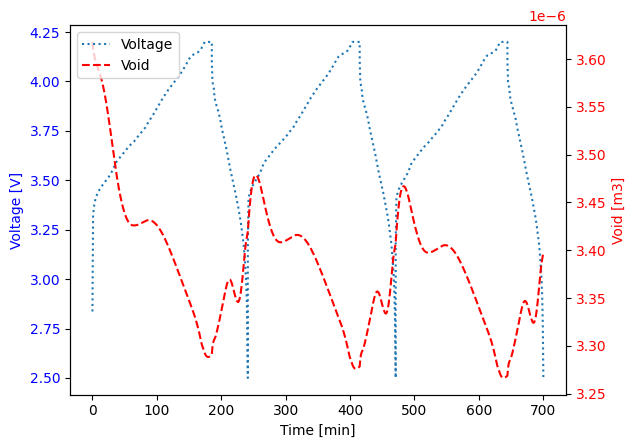

In [111]:
## thermal 
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, V_void , label="Void", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Void [m3]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

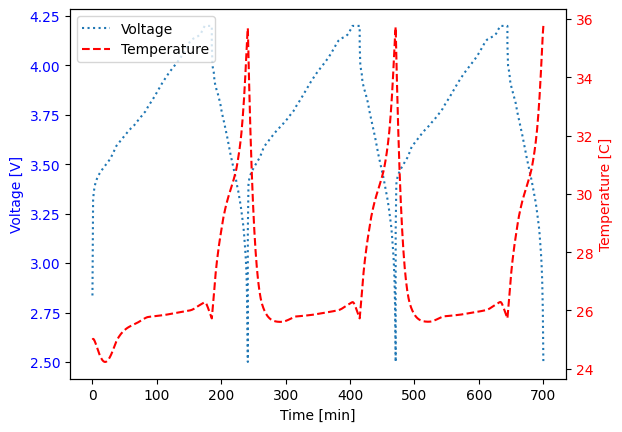

In [112]:
## thermal 
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, T_cell_C, label="Temperature", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Temperature [C]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

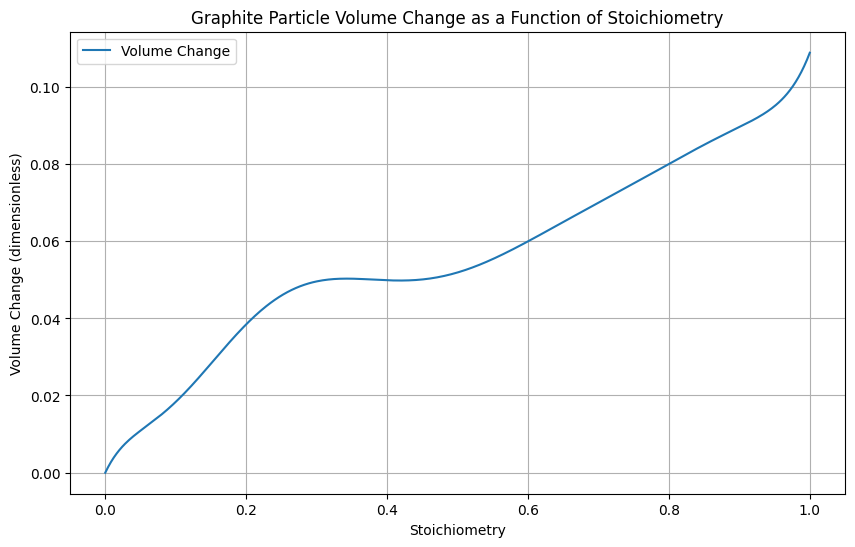

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def graphite_volume_change_Ai2020(sto):
    """
    Graphite particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`numpy.ndarray`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration

    Returns
    -------
    t_change: :class:`numpy.ndarray`
        volume change, dimensionless, normalised by particle volume
    """
    p1 = 145.907
    p2 = -681.229
    p3 = 1334.442
    p4 = -1415.710
    p5 = 873.906
    p6 = -312.528
    p7 = 60.641
    p8 = -5.706
    p9 = 0.386
    p10 = -4.966e-05
    t_change = (
        p1 * sto**9
        + p2 * sto**8
        + p3 * sto**7
        + p4 * sto**6
        + p5 * sto**5
        + p6 * sto**4
        + p7 * sto**3
        + p8 * sto**2
        + p9 * sto
        + p10
    )
    return t_change

# Define the range of stoichiometry
sto = np.linspace(0, 1, 500)

# Calculate the volume change
volume_change = graphite_volume_change_Ai2020(sto)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sto, volume_change, label='Volume Change')
plt.xlabel('Stoichiometry')
plt.ylabel('Volume Change (dimensionless)')
plt.title('Graphite Particle Volume Change as a Function of Stoichiometry')
plt.legend()
plt.grid(True)
plt.show()


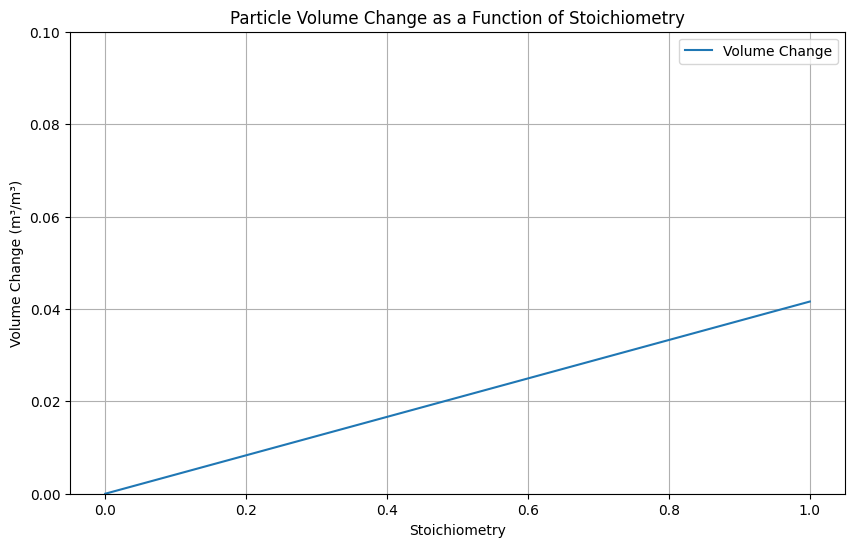

In [114]:
import numpy as np
import matplotlib.pyplot as plt

def volume_change_Ai2020(sto, c_s_max):
    """
    Particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`numpy.ndarray`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration
    c_s_max: float
        Maximum concentration in positive electrode [mol.m-3]

    Returns
    -------
    t_change: :class:`numpy.ndarray`
        Volume change, dimensionless, normalised by particle volume
    """
    omega = 7.88e-07  # Positive electrode partial molar volume [m3.mol-1]
    t_change = omega * c_s_max * sto
    return t_change

# Define the range of stoichiometry
sto = np.linspace(0, 1, 500)
c_s_max = param["Maximum concentration in positive electrode [mol.m-3]"]  # Maximum concentration in positive electrode [mol.m-3]

# Calculate the volume change
volume_change = volume_change_Ai2020(sto, c_s_max)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sto, volume_change, label='Volume Change')
plt.xlabel('Stoichiometry')
plt.ylabel('Volume Change (m³/m³)')
plt.ylim(0,0.1)
plt.title('Particle Volume Change as a Function of Stoichiometry')
plt.legend()
plt.grid(True)
plt.show()
